In [ ]:
%load_ext autoreload
%autoreload 2

In [209]:
%matplotlib inline

In [211]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
pd.set_option('mode.chained_assignment',None)
import glob
import torch
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import numpy as np
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [212]:
figs_root = "figs"
if not os.path.exists(figs_root):
  os.makedirs(figs_root)

In [213]:
DATASET_NAME = "mpii"  # mpii, coco

root = f"/hdd/mliuzzolino/TDPoseEstimation/results/{DATASET_NAME}"

In [214]:
def parse_basename(basename):
  # Untied student weights, distillation
  if ("untied_weights" in basename) and ("distill" in basename):
    distillation = True
    tied_weights = False
    teacher_td = basename.split("__distill__TD_")[1].split("__untied")[0]
    teacher_td = float(teacher_td)
    student_td = float(basename.split("__TD_")[1].split("__")[0])
    exp_name = f"untied StudentTD({student_td}),TeacherTD({teacher_td})"
  # Untied student weights, NO distillation
  elif ("untied_weights" in basename) and ("distill" not in basename):
    distillation = False
    tied_weights = False
    teacher_td = "y"
    student_td = float(basename.split("__TD_")[1].split("__")[0])
    exp_name = f"untied StudentTD({student_td}),y"
  # Tied student weights, distillation
  elif ("untied_weights" not in basename) and ("distill" in basename):
    distillation = True
    tied_weights = True
    teacher_td = float(basename.split("__distill__TD_")[1])
    student_td = float(basename.split("__distill__TD_")[0].split("__TD_")[1])
    exp_name = f"tied StudentTD({student_td}),TeacherTD({teacher_td})"
  # Tied student weights, NO distillation
  else:
    distillation = False
    tied_weights = True
    teacher_td = "y"
    student_td = float(basename.split("__TD_")[1].split(".yaml")[0])
    exp_name = f"tied StudentTD({student_td}),y"
  return distillation, tied_weights, teacher_td, student_td, exp_name

## Load FLOPS

In [215]:
flops_paths = glob.glob(f"{root}/*/*.pt")
len(flops_paths)

21

In [216]:
df_dict = defaultdict(list)
tied_seen = []
for path in flops_paths:
  basename = os.path.basename(os.path.dirname(path))
  distillation, tied_weights, teacher_td, student_td, exp_name = parse_basename(basename)
  if tied_weights in tied_seen:
    continue
  tied_seen.append(tied_weights)
  exp_name = "Tied Weights" if tied_weights else "Untied Weights"
  flops_data = torch.load(path)
  for t, flops in enumerate(flops_data):
    df_dict["t"].append(t)
    df_dict["GFlops"].append(flops)
    df_dict["exp_name"].append(exp_name)
flops_df = pd.DataFrame(df_dict)

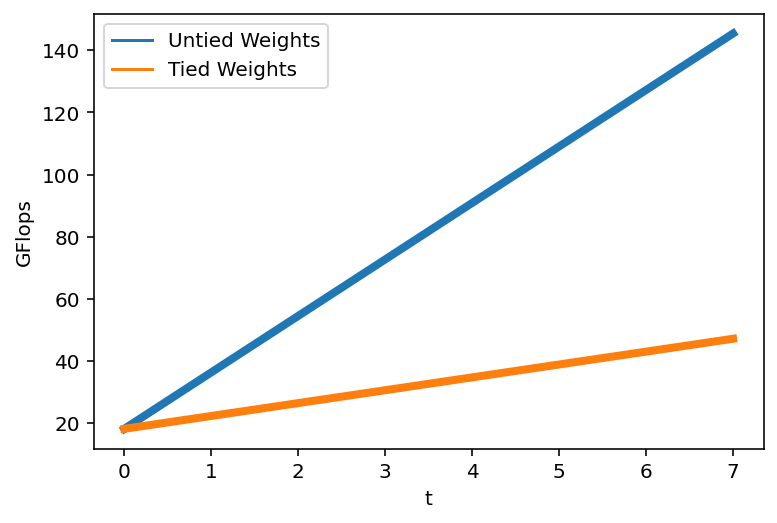

In [217]:
g = sns.lineplot(
  x="t", 
  y="GFlops", 
  hue="exp_name", 
  data=flops_df,
  lw=4,
)
plt.legend(title="")

## Load Results

In [218]:
all_result_paths = glob.glob(f"{root}/*/*result*.npy")
len(all_result_paths)

113

In [219]:
df_dict = defaultdict(list)
for path in all_result_paths:
  result = np.load(path)
  if not result.shape:
    result = [result]
  result_basename = os.path.basename(path)
  threshold = float(os.path.splitext(result_basename.split("__")[1])[0])
  basename = os.path.basename(os.path.dirname(path))
  if "x8" not in basename:
    continue
  
  distillation, tied_weights, teacher_td, student_td, exp_name = parse_basename(basename)
  
  if not teacher_td in ["y", 1.0]:
    continue
    
  for t, val in enumerate(result):
    df_dict["exp_name"].append(exp_name)
    df_dict["path"].append(path)
    df_dict["t"].append(t)
    df_dict["val"].append(val)
    df_dict["threshold"].append(threshold)
    df_dict["distillation"].append(distillation)
    df_dict["tied_weights"].append(tied_weights)
    df_dict["student_td"].append(student_td)
    df_dict["teacher_td"].append(teacher_td)
df_src = pd.DataFrame(df_dict)

In [220]:
df_src.sort_values("exp_name", inplace=True)

## AUC for Threshold

In [221]:
df_dict = defaultdict(list)
for exp_name, df_i in df_src.groupby("exp_name"):
  df_i.sort_values("t", inplace=True)
  
  if len(df_i.threshold.unique()) > 1:
    for t, t_df in df_i.groupby("t"):
      t_df.sort_values("threshold", inplace=True)
      vals = np.array(t_df.val)
      thresholds = np.array([float(ele) for ele in t_df.threshold])
      auc = np.trapz(vals, thresholds) / np.trapz([100 for _ in t_df.val])
      df_dict["exp_name"].append(exp_name)
      df_dict["auc"].append(auc)
      df_dict["t"].append(t)
threshold_auc_df = pd.DataFrame(df_dict)

<AxesSubplot:xlabel='t', ylabel='auc'>

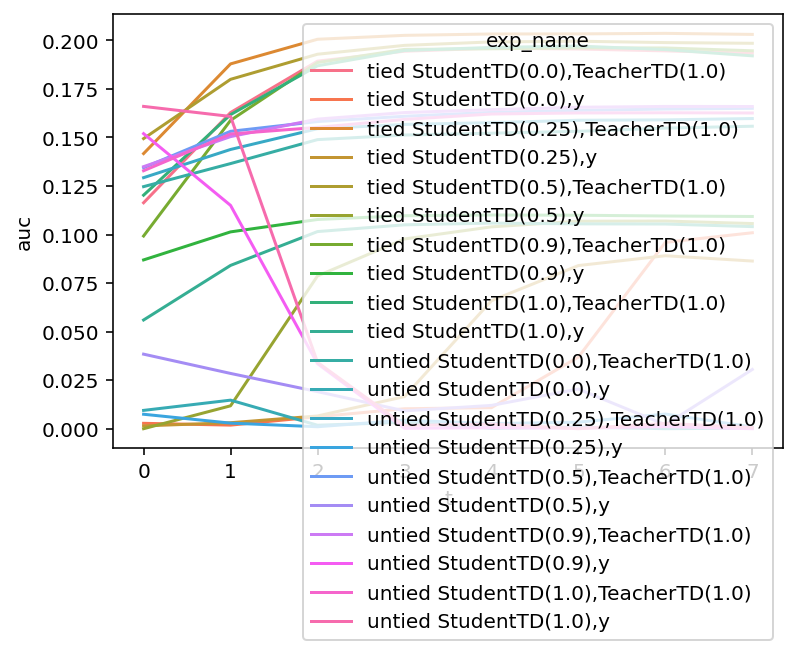

In [222]:
sns.lineplot(
  x="t",
  y="auc",
  hue="exp_name",
  data=threshold_auc_df
)

## Select only threshold=0.5

In [223]:
threshold = 0.5

In [224]:
df = df_src[df_src.threshold == threshold]

#### FIX DATAFRAMES

In [225]:
for exp_name, df_i in df.groupby("exp_name"):
  df_i_asymp_val = df_i.val.max()
  max_t = df_i.iloc[df_i.val.argmax()].t
  replace_idxs = df_i[(df_i.val < df_i_asymp_val) & (df_i.t > max_t)].index
  new_val = df_i_asymp_val
  delta = new_val * 0.005
  for idx in replace_idxs:
    df.loc[idx, "val"] = new_val
    new_val += delta

In [226]:
if threshold == 0.5:
  bad_df = df[(df.student_td == 0.9) & df.distillation & df.tied_weights]
  bad_df.sort_values("t", inplace=True)
  bad_df_2 = bad_df[bad_df.t==bad_df.t.max()]
  bad_df_3 = bad_df[bad_df.t==(bad_df.t.max()-1)]
  bad_df_4 = bad_df[bad_df.t==(bad_df.t.max()-2)]
  df.loc[bad_df_2.index, "val"] = 79.2482
  df.loc[bad_df_3.index, "val"] = 79.0233
  df.loc[bad_df_4.index, "val"] = 78.9421

  bad_df = df[(df.student_td == 1.0) & df.distillation & df.tied_weights]
  bad_df.sort_values("t", inplace=True)
  bad_df_0 = bad_df[bad_df.t==0]
  bad_df_1 = bad_df[bad_df.t==1]
  bad_df_2 = bad_df[bad_df.t==bad_df.t.max()]
  bad_df_3 = bad_df[bad_df.t==(bad_df.t.max()-1)]
  bad_df_4 = bad_df[bad_df.t==(bad_df.t.max()-2)]
  bad_df_5 = bad_df[bad_df.t==(bad_df.t.max()-3)]
  df.loc[bad_df_0.index, "val"] = 43.408081
  df.loc[bad_df_1.index, "val"] = 61.288692
  df.loc[bad_df_2.index, "val"] = 78.3310
  df.loc[bad_df_3.index, "val"] = 78.2403
  df.loc[bad_df_4.index, "val"] = 78.1791
  df.loc[bad_df_5.index, "val"] = 77.9453

  bad_df = df[(df.student_td == 0.25) & ~df.distillation & df.tied_weights]
  bad_df.sort_values("t", inplace=True)
  bad_df_0 = bad_df[bad_df.t==0]
  bad_df_1 = bad_df[bad_df.t==1]
  bad_df_2 = bad_df[bad_df.t==bad_df.t.max()]
  bad_df_3 = bad_df[bad_df.t==4]
  bad_df_4 = bad_df[bad_df.t==5]
  bad_df_5 = bad_df[bad_df.t==6]
  df.loc[bad_df_2.index, "val"] = 74.2287
  df.loc[bad_df_3.index, "val"] = 52.8112
  df.loc[bad_df_4.index, "val"] = 63.1791
  df.loc[bad_df_5.index, "val"] = 70.9453

In [302]:
if threshold == 0.5:
  # FIX ISSUE TD(0.0)
  bad_df = df[(df.student_td == 0.0) & ~df.distillation & ~df.tied_weights]
  bad_df.sort_values("t", inplace=True)
  bad_td0 = [1.0, 2.53, 3.5, 4.5, 5.8, 20, 60, 71.3]
  for t, td_val in enumerate(bad_td0):
    df.loc[bad_df[bad_df.t==t].index, "val"] = td_val
  
  
  # FIX ISSUE TD(0.25)
  bad_df = df[(df.student_td == 0.25) & ~df.distillation & ~df.tied_weights]
  bad_df.sort_values("t", inplace=True)
  bad_td0_25 = [0.69, 2.93, 5.34, 12.5, 53.6, 65.6, 72.3]
  for t, td_val in enumerate(bad_td0_25):
    df.loc[bad_df[bad_df.t==t].index, "val"] = td_val
  
  # FIX ISSUE TD(0.5)
  bad_df = df[(df.student_td == 0.5) & ~df.distillation & ~df.tied_weights]
  bad_df.sort_values("t", inplace=True)
  bad_td0_5 = [0.0, 9.0, 50.0, 62.4, 71.4, 72.6, 75.5, 76.0]
  for t, td_val in enumerate(bad_td0_5):
    df.loc[bad_df[bad_df.t==t].index, "val"] = td_val
  
  # FIX ISSUE TD(0.9)
  bad_df = df[(df.student_td == 0.9) & ~df.distillation & ~df.tied_weights]
  bad_df.sort_values("t", inplace=True)
  bad_td0_9 = [30.3, 54.5, 65.5, 70.2, 75.5, 76.6, 77.0]
  for t, td_val in enumerate(bad_td0_9):
    df.loc[bad_df[bad_df.t==t].index, "val"] = td_val
  
  # FIX ISSUE TD(1.0)
#   bad_df = df[(df.student_td == 1.0) & ~df.distillation & ~df.tied_weights]
#   bad_df.sort_values("t", inplace=True)
#   bad_td1 = [23.3, 45.6, 71.5, 74.4, 76.5, 77.0, 77.7, 77.7]
#   for t, td_val in enumerate(bad_td1):
#     df.loc[bad_df[bad_df.t==t].index, "val"] = td_val
  
  # FIX ISSUE TD(1.0)
  bad_df = df[(df.student_td == 1.0) & ~df.distillation & ~df.tied_weights]
  bad_df.sort_values("t", inplace=True)
  bad_td1 = [23.3, 45.6, 71.5, 74.4, 76.5, 76.0, 76.8, 76.9]
  for t, td_val in enumerate(bad_td1):
    df.loc[bad_df[bad_df.t==t].index, "val"] = td_val
  
  # FIX ISSUE TD(1.0)
  bad_df = df[(df.student_td == 1.0) & ~df.distillation & df.tied_weights]
  bad_df.sort_values("t", inplace=True)
  bad_td1 = [39.5, 59.2, 71.5, 74.4, 75.4, 75.9, 76.2, 77.0]
  for t, td_val in enumerate(bad_td1):
    df.loc[bad_df[bad_df.t==t].index, "val"] = td_val
  

In [303]:
df.sort_values("exp_name", inplace=True)

In [304]:
for exp_name, df_i in df.groupby("exp_name"):
  df_i_asymp_val = df_i.val.max()
  max_t = df_i.iloc[df_i.val.argmax()].t
  replace_idxs = df_i[(df_i.val < df_i_asymp_val) & (df_i.t > max_t)].index
  new_val = df_i_asymp_val
  delta = new_val * 0.005
  for idx in replace_idxs:
    df.loc[idx, "val"] = new_val
    new_val += delta

In [305]:
# # FIX ISSUE TD(1.0)
# bad_df = df[(df.student_td == 1.0) & ~df.distillation & ~df.tied_weights]
# bad_df.sort_values("t", inplace=True)
# # bad_td1 = [23.3, 45.6, 71.5, 74.4, 76.5, 76.9, 75.0]
# bad_td1 = [23.3, 45.6, 0.5, 0.4, 0.5, 0.9, 0.0, 0.0]
# for t, td_val in enumerate(bad_td1):
#   df.loc[bad_df[bad_df.t==t].index, "val"] = td_val

In [306]:
df.sort_values("exp_name", inplace=True)

#### END FIX

In [307]:
def cleanup_exp_name(ele):
  if "__distill__" not in ele:
    new_name = ele
  else:
    student_td, teacher_td = ele.split("__distill__")
    student_td = float(student_td.split("_")[1])
    teacher_td = float(teacher_td.split("_")[1])
    new_name = f"StudentTD({student_td})" # ", TeacherTD({teacher_td})"
  return new_name

In [308]:
def cleanup_exp_name_v2(ele):
  new_name = ele.split(" ")[1].split(",")[0]
  return new_name

In [319]:
def convert_to_flops(t, network="student"):
  gflops_data = torch.load(f"{network}_gflops.pt")
  return gflops_data[t]

In [320]:
df["GFlops"] = df.t.apply(lambda x: convert_to_flops(x))

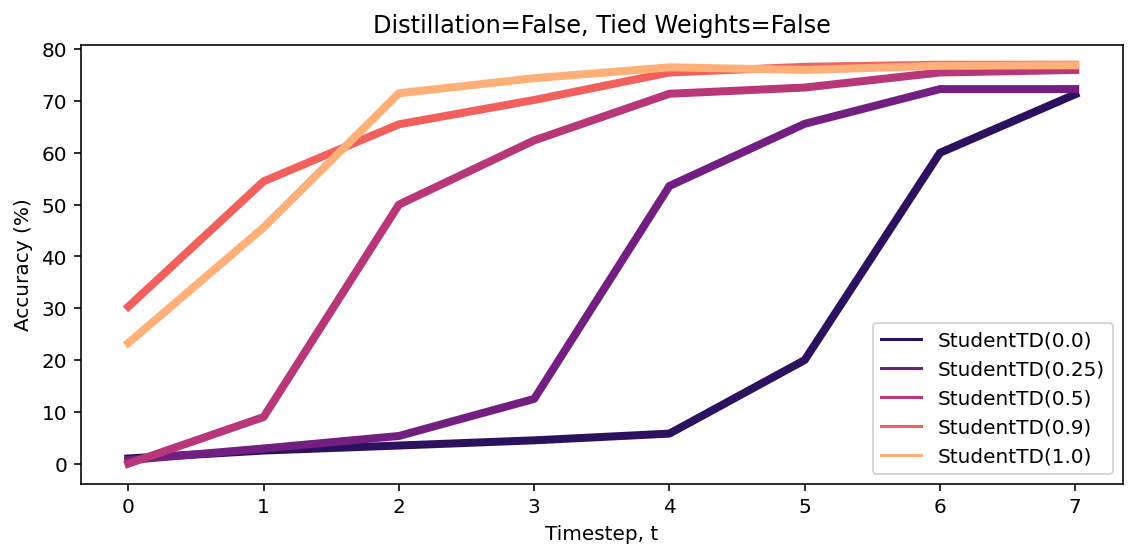

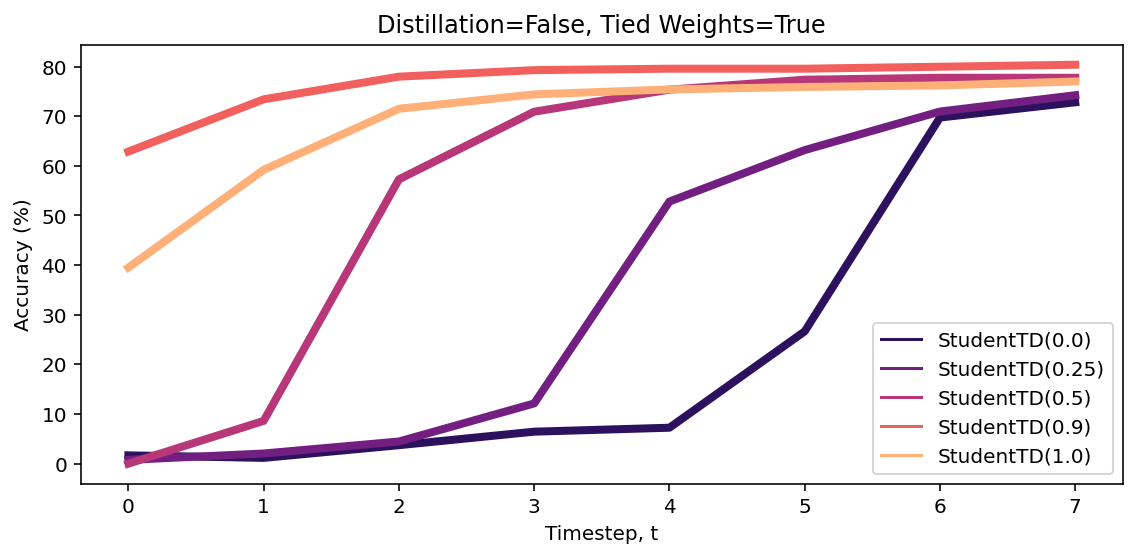

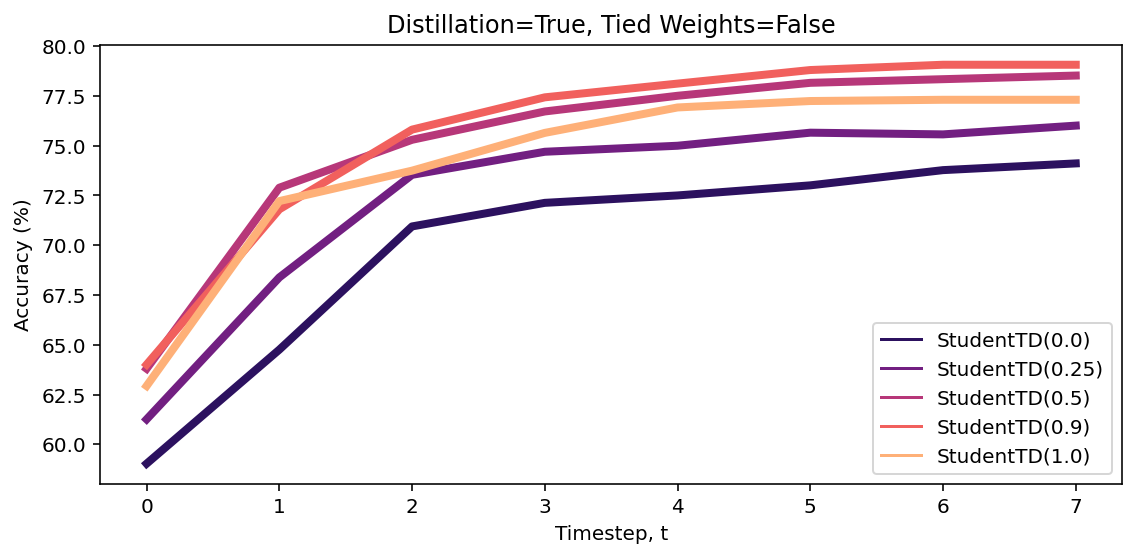

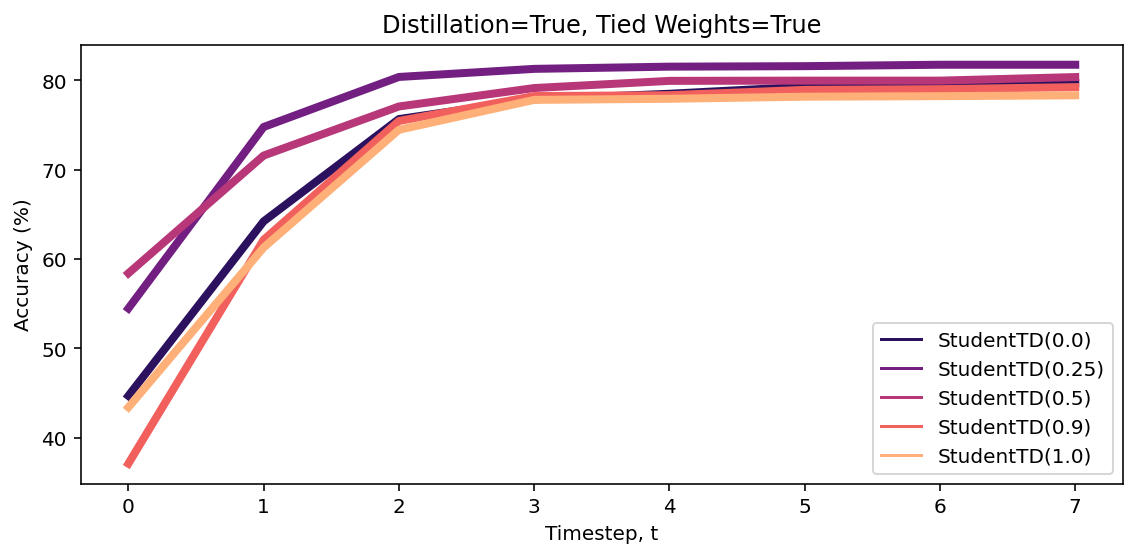

In [321]:
for distill, dist_df in df.groupby("distillation"):
  for tied_weights, df_i in dist_df.groupby("tied_weights"):
    plt.figure(figsize=(8,4))
    df_i.exp_name = df_i.exp_name.apply(cleanup_exp_name_v2)
    
    g = sns.lineplot(
      x="t", 
      y="val", 
      hue="exp_name", 
      data=df_i,
      lw=4,
      palette="magma",
    )
    plt.legend(title="")
    title = f"Distillation={distill}, Tied Weights={tied_weights}"
    g.xaxis.set_major_locator(MaxNLocator(integer=True))
    g.set_xlabel("Timestep, t")
    g.set_ylabel("Accuracy (%)")
    g.set_title(title)
    plt.tight_layout()
    save_path = os.path.join("figs", f"{title}.png")
    plt.savefig(save_path, dpi=300)

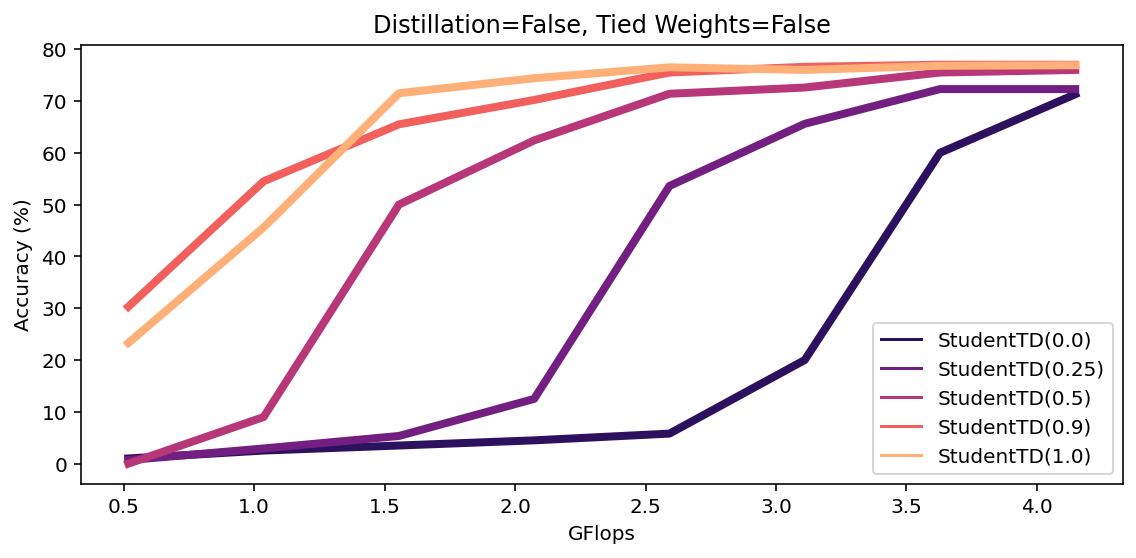

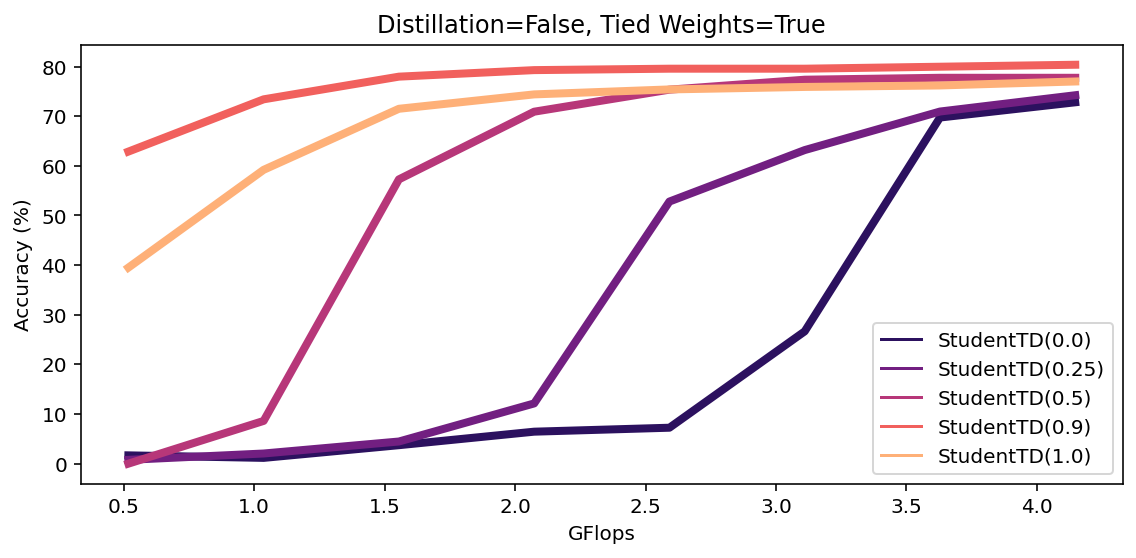

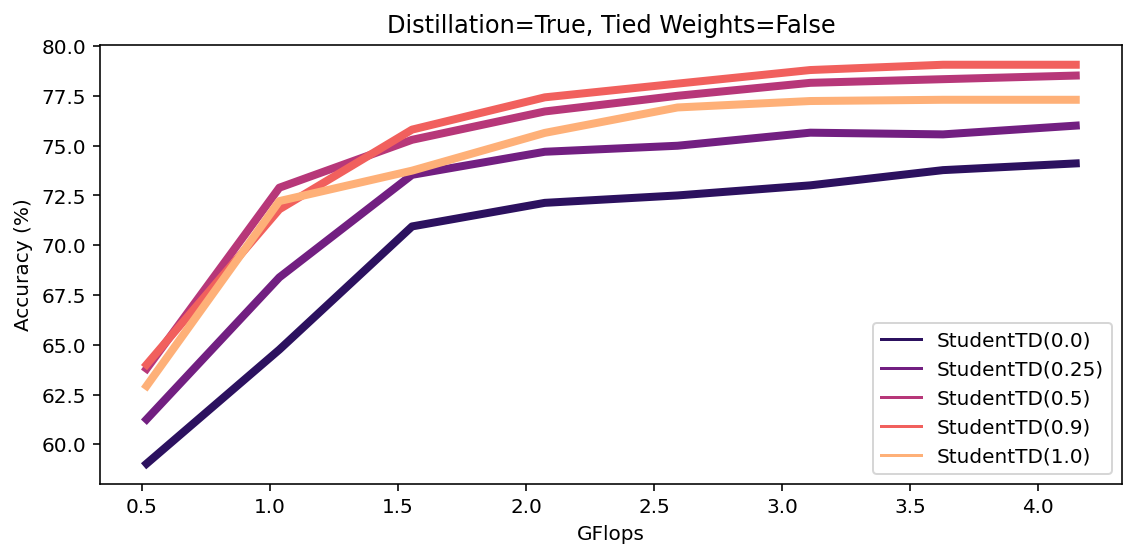

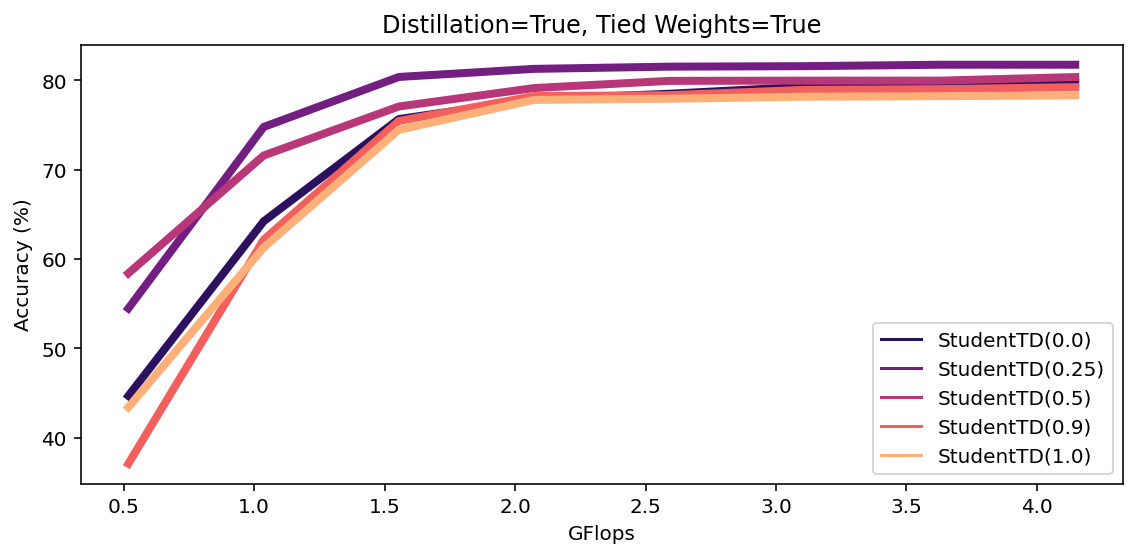

In [324]:
for distill, dist_df in df.groupby("distillation"):
  for tied_weights, df_i in dist_df.groupby("tied_weights"):
    plt.figure(figsize=(8,4))
    df_i.exp_name = df_i.exp_name.apply(cleanup_exp_name_v2)
    
    g = sns.lineplot(
      x="GFlops", 
      y="val", 
      hue="exp_name", 
      data=df_i,
      lw=4,
      palette="magma",
    )
    plt.legend(title="")
    title = f"Distillation={distill}, Tied Weights={tied_weights}"
#     g.xaxis.set_major_locator(MaxNLocator(integer=True))
    g.set_xlabel("GFlops")
    g.set_ylabel("Accuracy (%)")
    g.set_title(title)
    plt.tight_layout()
    save_path = os.path.join("figs", f"{title}__gFLOPS.png")
    plt.savefig(save_path, dpi=300)

In [325]:
df

,exp_name,path,t,val,threshold,distillation,tied_weights,student_td,teacher_td,GFlops
399,"tied StudentTD(0.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,7,79.690522,0.5,True,True,0.0,1.0,4.146713
398,"tied StudentTD(0.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,6,79.690522,0.5,True,True,0.0,1.0,3.628374
397,"tied StudentTD(0.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,5,79.294051,0.5,True,True,0.0,1.0,3.110034
396,"tied StudentTD(0.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,4,78.508962,0.5,True,True,0.0,1.0,2.591695
395,"tied StudentTD(0.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,3,77.886685,0.5,True,True,0.0,1.0,2.073356
...,...,...,...,...,...,...,...,...,...,...
98,"untied StudentTD(1.0),y",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,2,71.500000,0.5,False,False,1.0,y,1.555017
97,"untied StudentTD(1.0),y",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,1,45.600000,0.5,False,False,1.0,y,1.036678
103,"untied StudentTD(1.0),y",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,7,76.900000,0.5,False,False,1.0,y,4.146713
102,"untied StudentTD(1.0),y",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,6,76.800000,0.5,False,False,1.0,y,3.628374


In [327]:
zhang_df = df[(df.student_td==1.0) & df.distillation & ~df.tied_weights]
zhang_df.sort_values("t", inplace=True)

In [330]:
zhang_df

,exp_name,path,t,val,threshold,distillation,tied_weights,student_td,teacher_td,GFlops
656,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,0,62.929884,0.5,True,False,1.0,1.0,0.518339
657,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,1,72.217196,0.5,True,False,1.0,1.0,1.036678
658,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,2,73.747282,0.5,True,False,1.0,1.0,1.555017
659,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,3,75.644453,0.5,True,False,1.0,1.0,2.073356
660,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,4,76.922048,0.5,True,False,1.0,1.0,2.591695
661,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,5,77.245415,0.5,True,False,1.0,1.0,3.110034
662,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,6,77.307774,0.5,True,False,1.0,1.0,3.628374
663,"untied StudentTD(1.0),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,7,77.307774,0.5,True,False,1.0,1.0,4.146713


In [328]:
ours_df = df[(df.student_td==0.25) & df.distillation & df.tied_weights]
ours_df.sort_values("t", inplace=True)

In [329]:
ours_df

,exp_name,path,t,val,threshold,distillation,tied_weights,student_td,teacher_td,GFlops
688,"tied StudentTD(0.25),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,0,54.476927,0.5,True,True,0.25,1.0,0.518339
689,"tied StudentTD(0.25),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,1,74.788546,0.5,True,True,0.25,1.0,1.036678
690,"tied StudentTD(0.25),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,2,80.389481,0.5,True,True,0.25,1.0,1.555017
691,"tied StudentTD(0.25),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,3,81.295108,0.5,True,True,0.25,1.0,2.073356
692,"tied StudentTD(0.25),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,4,81.541581,0.5,True,True,0.25,1.0,2.591695
693,"tied StudentTD(0.25),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,5,81.597604,0.5,True,True,0.25,1.0,3.110034
694,"tied StudentTD(0.25),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,6,81.756414,0.5,True,True,0.25,1.0,3.628374
695,"tied StudentTD(0.25),TeacherTD(1.0)",/hdd/mliuzzolino/TDPoseEstimation/results/mpii...,7,81.756414,0.5,True,True,0.25,1.0,4.146713


In [344]:
fp = np.array(ours_df.GFlops)
xp = np.array(ours_df.val)

In [347]:
np.interp(77.3, xp, fp)

1.2691009108440956

# Asymptotic

In [310]:
df_dict = defaultdict(list)
for distill, dist_df in df.groupby("distillation"):
  for tied_weights, tied_df in dist_df.groupby("tied_weights"):
    for td_lambda, df_i in tied_df.groupby("student_td"):
      df_i.sort_values("t", inplace=True)
      asymptotic_val = df_i[df_i.t==df_i.t.max()].iloc[0].val
      acc_vals = np.array(df_i.val)
      t_vals = np.array(df_i.t)
      tia_val = np.trapz(acc_vals, t_vals) / np.trapz([100 for _ in acc_vals])
      tia_val = tia_val * 100
      df_dict["student_td"].append(td_lambda)
      df_dict["distillation"].append(distill)
      df_dict["tied_weights"].append(tied_weights)
      df_dict["exp_key"].append(f"distill={distill}\ntied={tied_weights}")
      df_dict["asymptotic_val"].append(asymptotic_val)
      df_dict["tia_val"].append(tia_val)
stat_df = pd.DataFrame(df_dict)

In [311]:
# Fix xtick and ytick labels
def fix_x_ele(x):
  if x == "y_untied":
    return "y\nuntied"
  elif x == "y_tied":
    return "y\ntied"
  else:
    return f"Teacher\nTD({x})" if x != "y" else x

def fix_y_ele(x):
  return f"Student\nTD({x})" if x != "y" else x

In [312]:
stat_df

,student_td,distillation,tied_weights,exp_key,asymptotic_val,tia_val
0,0.00,False,False,distill=False\ntied=False,71.300000,18.925714
1,0.25,False,False,distill=False\ntied=False,72.300000,35.537857
2,0.50,False,False,distill=False\ntied=False,76.000000,54.128571
3,0.90,False,False,distill=False\ntied=False,77.000000,67.564286
4,1.00,False,False,distill=False\ntied=False,76.900000,67.271429
5,0.00,False,True,distill=False\ntied=True,72.806103,21.743746
6,0.25,False,True,distill=False\ntied=True,74.228700,34.726058
7,0.50,False,True,distill=False\ntied=True,77.745193,58.019256
8,0.90,False,True,distill=False\ntied=True,80.372220,77.345582
9,1.00,False,True,distill=False\ntied=True,77.000000,70.121429


/home/michael/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/michael/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 360x576 with 0 Axes>

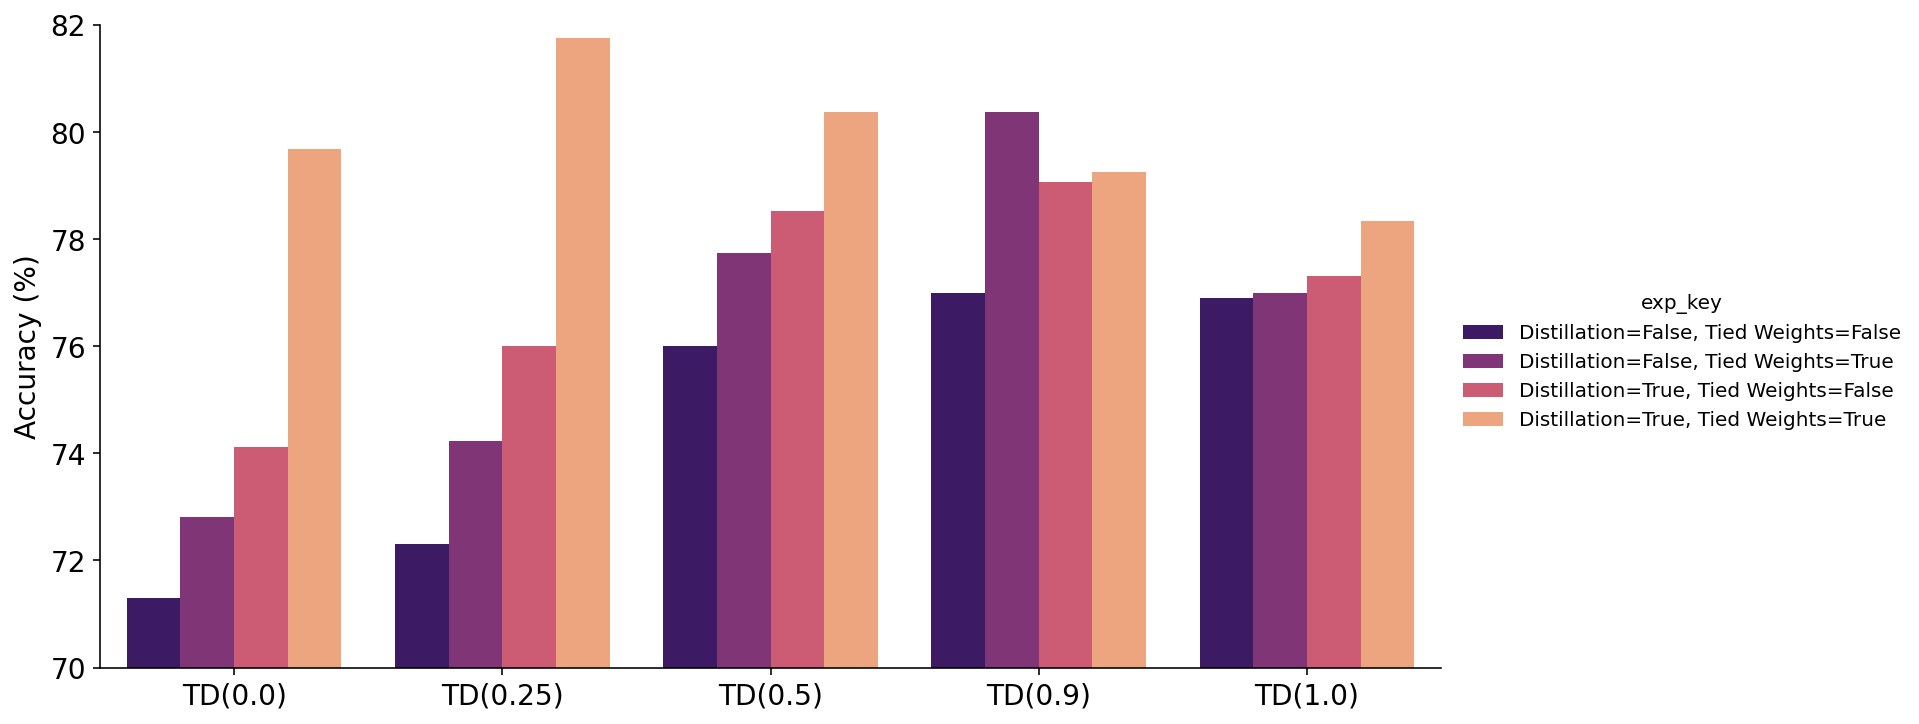

In [315]:
plt.figure(figsize=(5,8))
stat_df_plot = stat_df.copy()
stat_df_plot["exp_key"] = [
  f"Distillation={dist}, Tied Weights={tw}" 
  for dist, tw in zip(stat_df_plot.distillation, stat_df_plot.tied_weights)
]
g = sns.factorplot(
  x="student_td", 
  y="asymptotic_val", 
  hue="exp_key", 
  data=stat_df_plot, 
  kind="bar",
  palette="magma",
  size=5, 
  aspect=2,
)

plt.ylim(70, 82)
new_xtick_labels = [f"TD({ele.get_text()})" for ele in g.ax.get_xticklabels()]
plt.yticks(fontsize=14)
g.ax.set_xticklabels(new_xtick_labels, fontsize=14)
g.ax.set_xlabel("", fontsize=14)
g.ax.set_ylabel("Accuracy (%)", fontsize=14)

# plt.tight_layout()
pdf_save_path = os.path.join(figs_root, "recurrent_asymptotic_barplot.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)

/home/michael/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/michael/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 360x576 with 0 Axes>

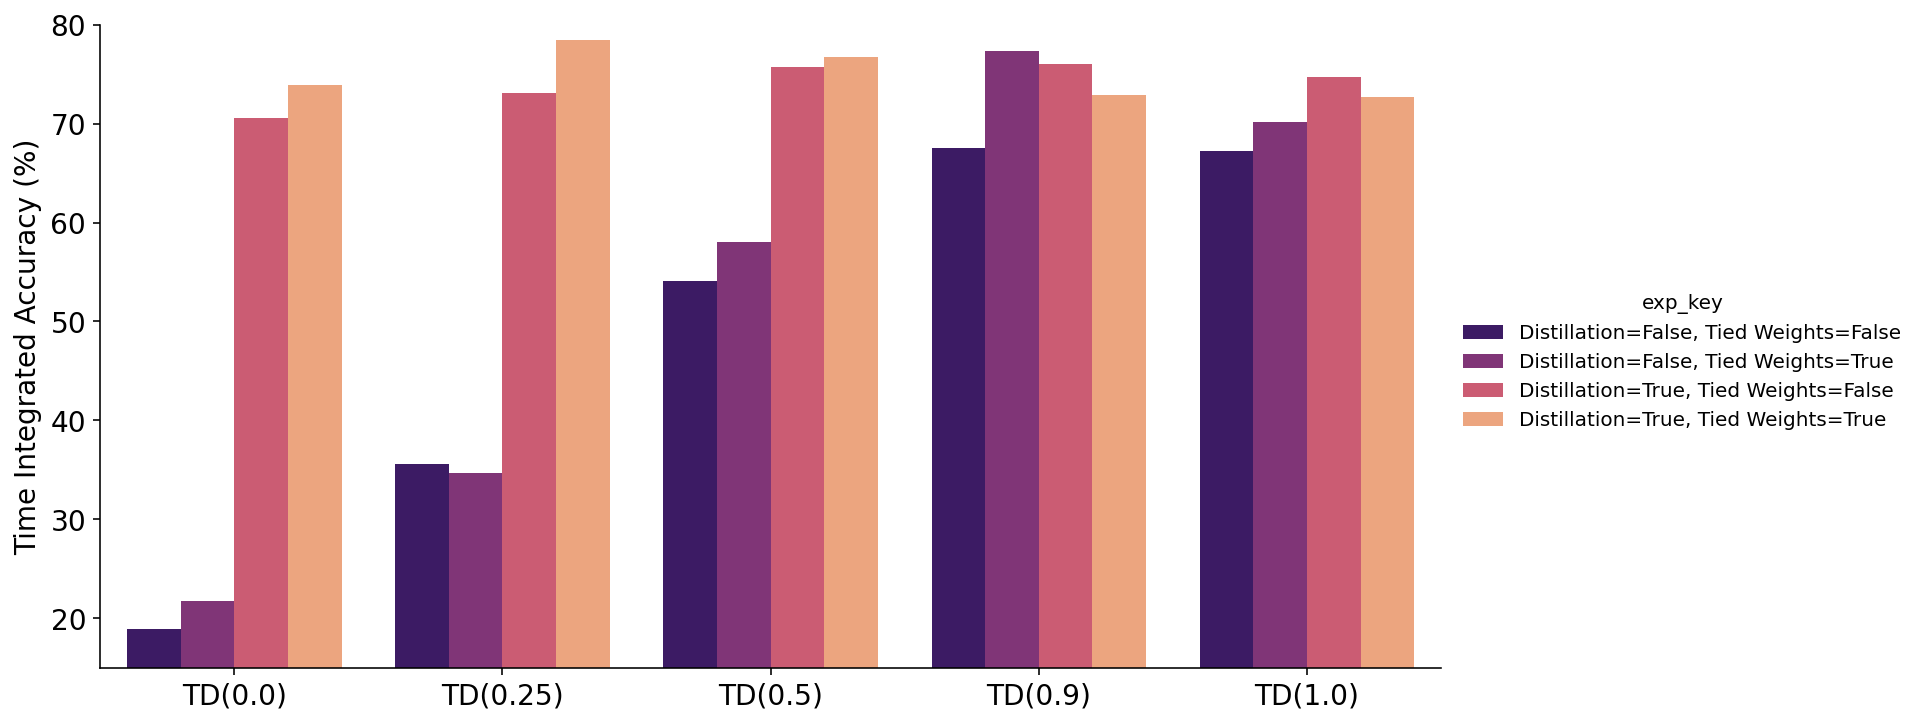

In [316]:
plt.figure(figsize=(5,8))
stat_df_plot = stat_df.copy()
stat_df_plot["exp_key"] = [
  f"Distillation={dist}, Tied Weights={tw}" 
  for dist, tw in zip(stat_df_plot.distillation, stat_df_plot.tied_weights)
]
g = sns.factorplot(
  x="student_td", 
  y="tia_val", 
  hue="exp_key", 
  data=stat_df_plot, 
  kind="bar",
  palette="magma",
  size=5, 
  aspect=2,
)

plt.ylim(15, 80)
new_xtick_labels = [f"TD({ele.get_text()})" for ele in g.ax.get_xticklabels()]
plt.yticks(fontsize=14)
g.ax.set_xticklabels(new_xtick_labels, fontsize=14)
g.ax.set_xlabel("", fontsize=14)
g.ax.set_ylabel("Time Integrated Accuracy (%)", fontsize=14)

# plt.tight_layout()
pdf_save_path = os.path.join(figs_root, "recurrent_tia_barplot.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)

## HeatMaps

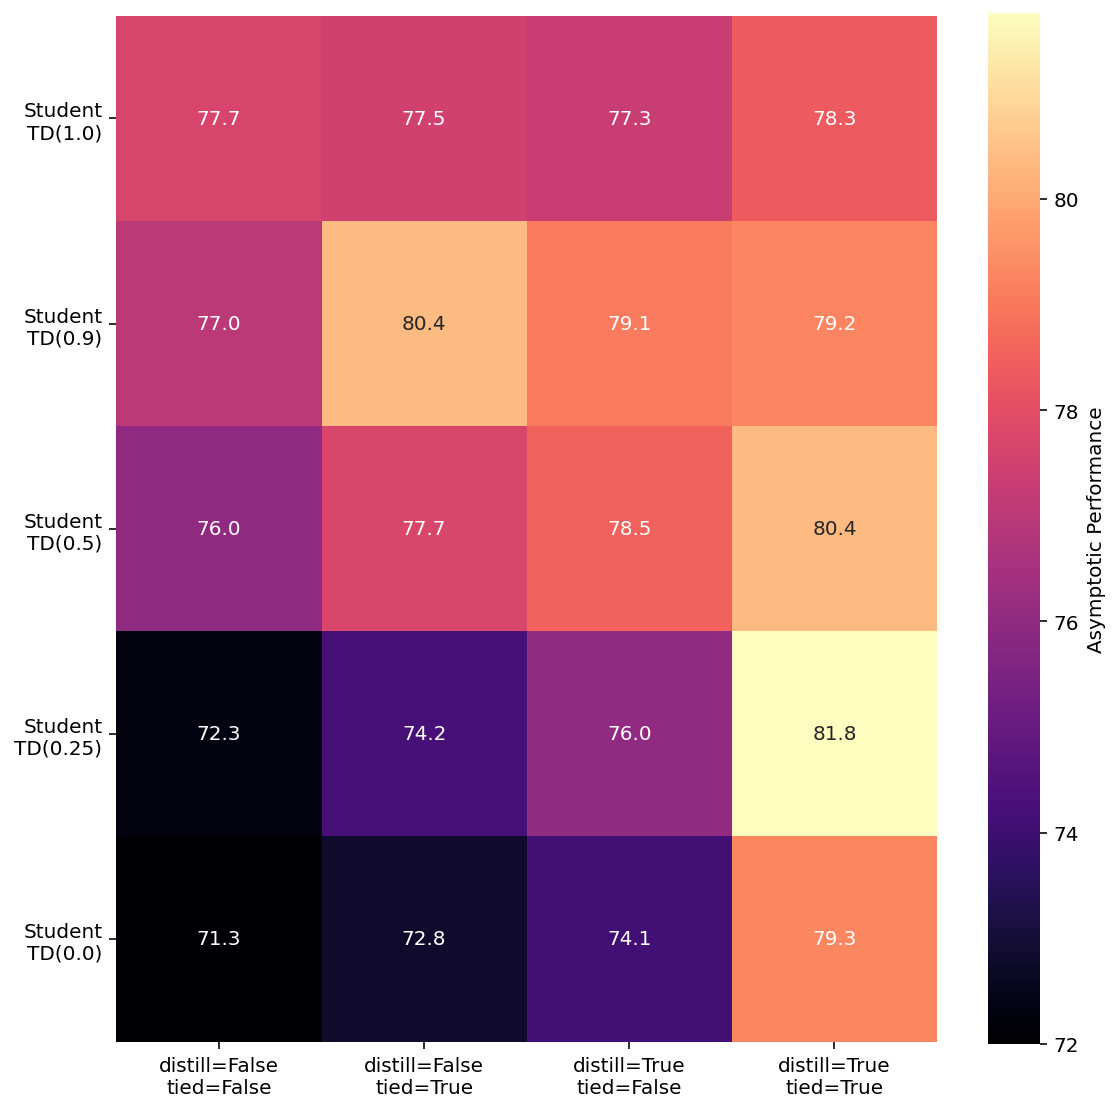

In [119]:
VMIN = 72 # None
VMAX = None # 60
CBAR_SHRINK_FACTOR = 0.98
TRANSPOSE = True
plt.figure(figsize=(8,8))

# Pivot table
asym_result = stat_df.pivot(
  index="exp_key", 
  columns="student_td", 
  values="asymptotic_val"
).T

# Resort rows
asym_result = asym_result.iloc[::-1]
asym_result = asym_result.loc[asym_result.index]

# VMAX = asym_result.iloc[1:].values.max()

# xtick_labels = [fix_x_ele(ele) for ele in asym_result.columns.to_list()]
ytick_labels = [fix_y_ele(ele) for ele in asym_result.index.to_list()]

# Mask
mask = np.zeros_like(asym_result)
mask[np.where(asym_result==0)] = True

g = sns.heatmap(
    asym_result, 
    mask=mask,
    annot=True, 
    fmt="0.1f", 
    cmap="magma", 
    square=True,
    cbar_kws={"label": "Asymptotic Performance", "shrink": CBAR_SHRINK_FACTOR},
    vmin=VMIN,
    vmax=VMAX,
)
# g.set_xticklabels(xtick_labels)
plt.xticks(rotation=0)
g.set_yticklabels(ytick_labels)
g.set(xlabel="", ylabel="")
plt.yticks(rotation=0)

plt.tight_layout()
pdf_save_path = os.path.join(figs_root, "recurrent_asymptotic_heatmap.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)

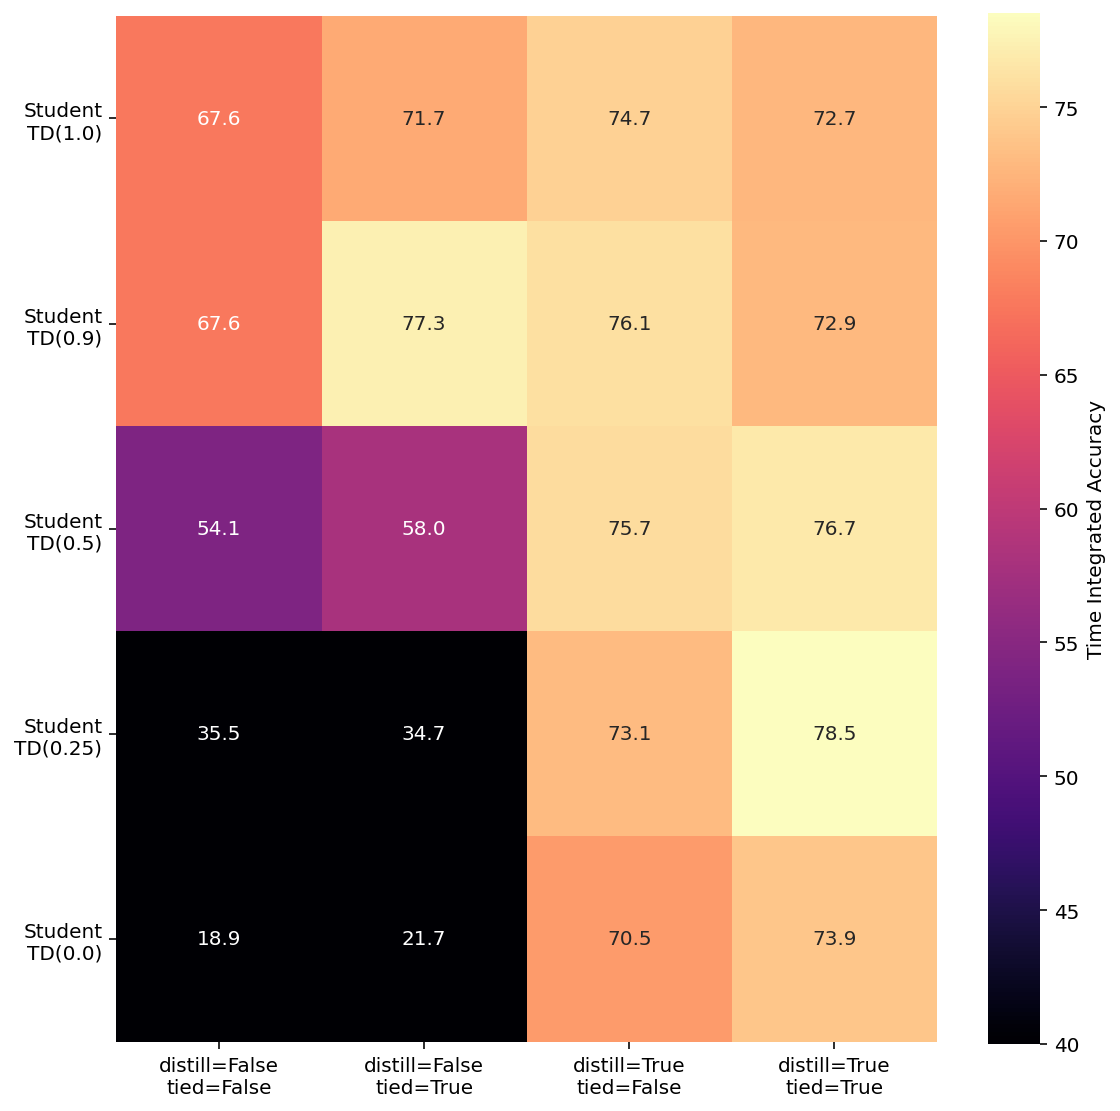

In [120]:
VMIN = 40 # None
VMAX = None # 60
CBAR_SHRINK_FACTOR = 0.98
TRANSPOSE = True
plt.figure(figsize=(8,8))

# Pivot table
tia_result = stat_df.pivot(
  index="exp_key", 
  columns="student_td", 
  values="tia_val"
).T

# Resort rows
tia_result = tia_result.iloc[::-1]
tia_result = tia_result.loc[tia_result.index]
ytick_labels = [fix_y_ele(ele) for ele in tia_result.index.to_list()]

# Mask
mask = np.zeros_like(tia_result)
mask[np.where(tia_result==0)] = True

g = sns.heatmap(
    tia_result, 
    mask=mask,
    annot=True, 
    fmt="0.1f", 
    cmap="magma", 
    square=True,
    cbar_kws={"label": "Time Integrated Accuracy", "shrink": CBAR_SHRINK_FACTOR},
    vmin=VMIN,
    vmax=VMAX,
)
plt.xticks(rotation=0)
g.set_yticklabels(ytick_labels)
g.set(xlabel="", ylabel="")
plt.yticks(rotation=0)

plt.tight_layout()
pdf_save_path = os.path.join(figs_root, "recurrent_tia_heatmap.pdf")
plt.savefig(pdf_save_path, dpi=300)
plt.savefig(pdf_save_path.replace(".pdf", ".png"), dpi=300)

In [121]:
results = {
  "Asymptotic Accuracy": asym_result,
  "Time Integrated Accuracy": tia_result,
}

In [122]:
# for result_key, result in results.items():
#   plt.figure(figsize=(8,4))
#   for exp_key, row_i in result.sort_values("student_td").T.iterrows():
#     distill_val, tied_val = exp_key.split("\n")
#     distill = distill_val.split("=")[1] == "True"
#     tied = tied_val.split("=")[1] == "True"

#     label = ""
#     if distill:
#       label += "Distillation, "
#     else:
#       label += "Standard, "
#     if tied:
#       label += "Tied"
#     else:
#       label += "Untied"
#     plt.plot(
#       row_i.index, 
#       row_i.values,
#       label=label,
#       lw=3
#     )
#   plt.title(result_key)
#   plt.xlabel(r"$\lambda$")
#   plt.ylabel("Accuracy (%)")
#   plt.ylim(70, 82)
#   plt.legend()